# Logistic Regression, Ridge and Lasso Regression
@Yuwei Hsu

# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# Set the graph size
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (24,8)

# Logistic Regression:
## Predict the reasons that people are going to leave the company.

## EDA

### Acquire data

In [ ]:
path_1 = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSzbNvy6VkpDeHgxTjzBPsA4v8FwJbLtclQscxUdngJLZ3ERLi1AjeZjeXBz5cCJQQPqLvKkDce46s5/pub?gid=503476343&single=true&output=csv"
df1 = pd.read_csv(path_1)
df1.shape

(11249, 10)

In [ ]:
df1.head()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept,salary
0,0.82,0.97,3,244,5,0,0,0,SALES,MEDIUM
1,0.75,0.81,2,247,4,0,0,0,HR,SMALL
2,0.54,0.81,4,257,2,0,0,0,ADMIN,SMALL
3,0.60,0.65,4,160,2,0,0,0,IS,SMALL
4,0.85,0.92,4,151,3,1,0,0,IS,MEDIUM


### Description of quantitative variables

In [ ]:
df1.describe()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years
count,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000
mean,0.612957,0.716225,3.799716,201.176727,3.499600,0.144991,0.239577,0.021869
std,0.248235,0.171378,1.232190,50.058105,1.469892,0.352107,0.426844,0.146261
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,201.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


- The values of workload are recorded as numerical variable, however, it is categorical variable that describes different levels of workload.
- The mean of attrit in this dataset is around 0.24.


In [ ]:
# Count the frequency of attrit
df1['attrit'].value_counts()

0    8554
1    2695
Name: attrit, dtype: int64

- 2695 out of 11249 people are going to leave the company.

In [ ]:
# Get the mean of each feature, group by atrrit
df1.groupby('attrit').mean()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,promo_in_last_5_years
attrit,,,,,,,
0,0.667108,0.715087,3.779635,198.999766,3.379238,0.175473,0.027473
1,0.441080,0.719837,3.863451,208.086456,3.881633,0.048237,0.004082


It is not suprising to see:
- The average of employee satisfication of people are going to leave the company(0.441) is lower than the mean of employee satisfication of people are not leaving(0.667) and the whole dataset(0.613).
- The mean of who has promotion in last five years and who is going to leave the company(0.004) is much more lower than the average.

Text(4.703777430555554, 0.5, 'Frequency')

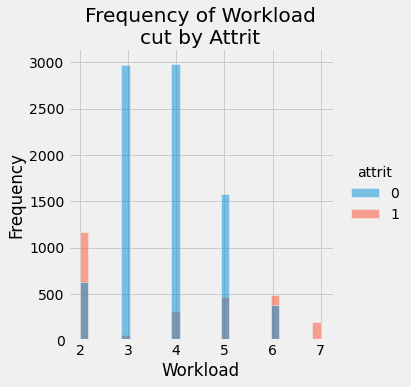

In [ ]:
# Plot the frequecy of workload cut by attrit
ax = sns.displot(df1,x = 'workload',hue = 'attrit')
plt.title('Frequency of Workload\ncut by Attrit')
plt.xlabel('Workload')
plt.ylabel('Frequency')

- We can see that the frequency of attrition depends a great deal on the workload levels from the plot shown above.

### Description of qualitative variables

Text(0, 0.5, 'Density')

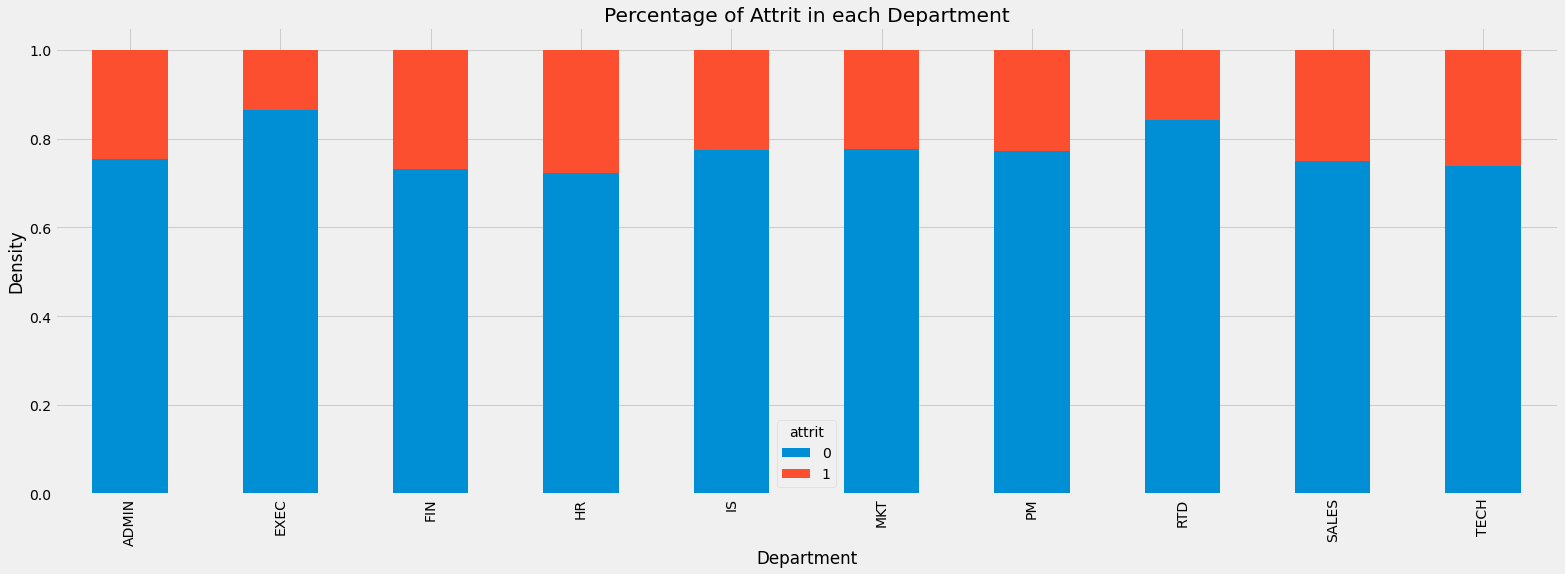

In [ ]:
# Draw stack bar char of dept cut by attrit
table_dept = pd.crosstab(df1.dept,df1.attrit)
table_dept.div(table_dept.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Percentage of Attrit in each Department')
plt.xlabel('Department')
plt.ylabel('Density')

- Each department is more or less around 0.8 percentage of attrition, it may not be helpful to prediction.

Text(0, 0.5, 'Frequency')

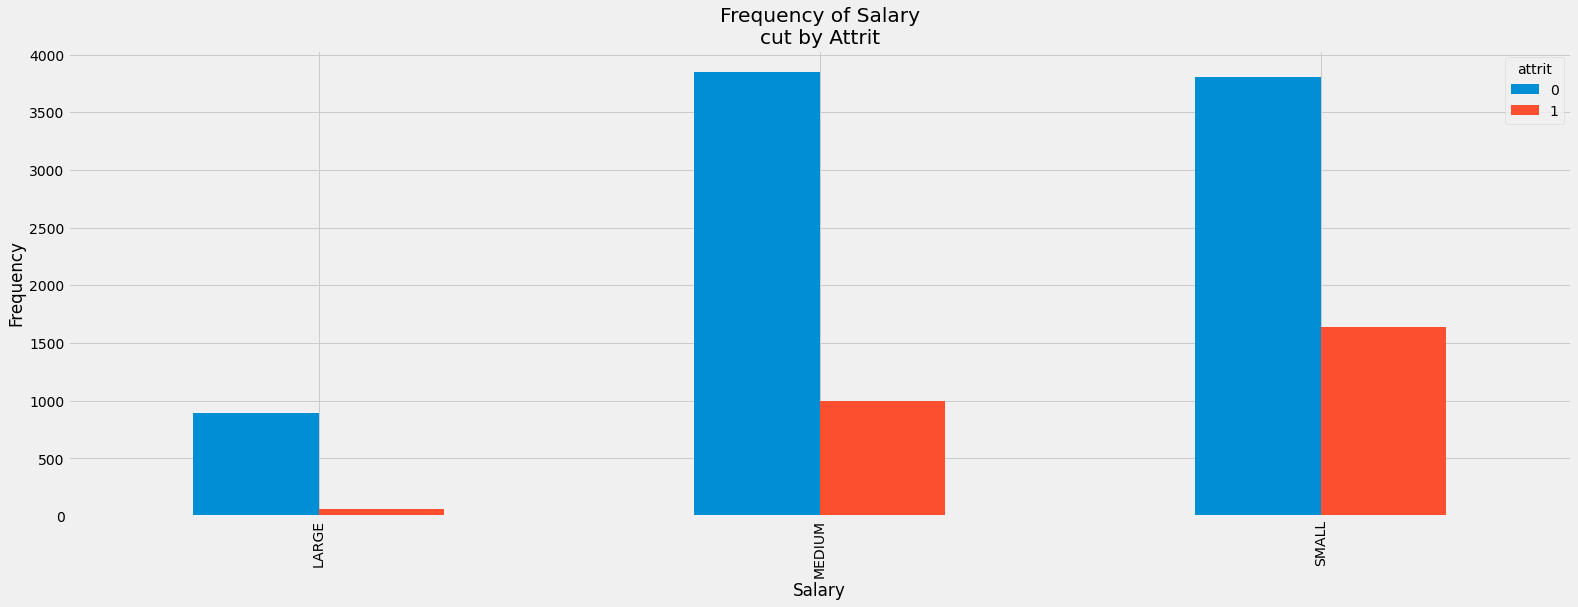

In [ ]:
# Plot the frequency of salary cut by attrit
pd.crosstab(df1.salary,df1.attrit).plot(kind='bar')
plt.title('Frequency of Salary\ncut by Attrit')
plt.xlabel('Salary')
plt.ylabel('Frequency')

- The plot above shows that the positive attrition varies depending on salary amont, which might be a good predictor.

In [ ]:
# Contingency table(and percentage) of ergo_issue and attrit
table_ergo = pd.crosstab(df1.ergo_issues,df1.attrit)
table_ergopct = table_ergo.astype('float').div(table_ergo.sum(axis=1),axis=0)*100.00
table_ergo

attrit,0,1
ergo_issues,,
0,7053,2565
1,1501,130


In [ ]:
# Contingency table(and percentage) of promo_in_last_5_years and attrit
table_promoted = pd.crosstab(df1.promo_in_last_5_years,df1.attrit)
table_promotedpct = table_promoted.astype('float').div(table_promoted.sum(axis=1),axis=0)*100.00
table_promoted

attrit,0,1
promo_in_last_5_years,,
0,8319,2684
1,235,11


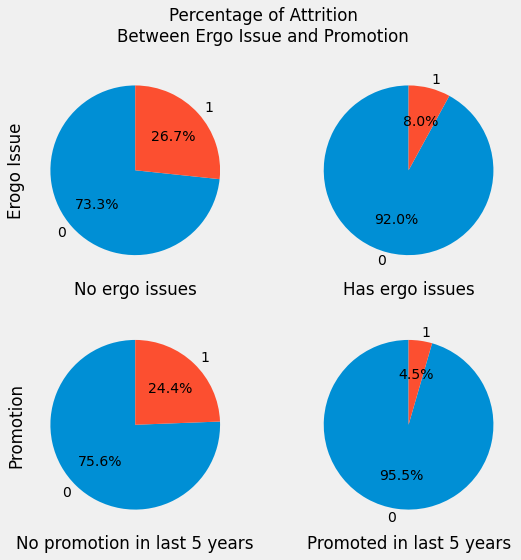

In [ ]:
# Draw the pie charts of the percentage of attrit between ergo_issue and promo_in_last_5_years
label = table_ergopct.columns
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize = (8,8))
ax1.pie(table_ergopct.loc[0], labels = label, autopct='%1.1f%%', startangle=90)
ax2.pie(table_ergopct.loc[1], labels = label,autopct='%1.1f%%', startangle=90)
ax3.pie(table_promotedpct.loc[0],labels = label,autopct ='%1.1f%%', startangle=90)
ax4.pie(table_promotedpct.loc[1],labels = label, autopct ='%1.1f%%', startangle=90)
ax1.set_xlabel('No ergo issues')
ax2.set_xlabel('Has ergo issues')
ax3.set_xlabel('No promotion in last 5 years')
ax4.set_xlabel('Promoted in last 5 years')
ax1.set_ylabel('Erogo Issue')
ax3.set_ylabel('Promotion')
fig.suptitle('Percentage of Attrition\nBetween Ergo Issue and Promotion')
plt.show()

- The precentage of attrition for each group varies widely; hence, ergo_issue and promo_in_last_5_years might both be good predictor for the outcome.

## Implement Logistic Regression

### Create dummy variables for categorical features


In [ ]:
# Show the column names
list(df1.columns)

['employee_satisfaction',
 'last_performance_rating',
 'workload',
 'avg_montly_hours',
 'tenure_years',
 'ergo_issues',
 'attrit',
 'promo_in_last_5_years',
 'dept',
 'salary']

In [ ]:
# Create dummy variables for each categorical feature, then join them into df1 dataframe
cat_vars=['workload','ergo_issues','promo_in_last_5_years','dept','salary']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df1[var], prefix=var)
    df_t=df1.join(cat_list)
    df1=df_t

# Remove the original categorical variables
df1_vars=df1.columns.values.tolist()
to_keep=[i for i in df1_vars if i not in cat_vars]

# Select the converted categorical variables and numerical variables as new dataframe 
df1_final=df1[to_keep]
df1_final.columns.values

array(['employee_satisfaction', 'last_performance_rating',
       'avg_montly_hours', 'tenure_years', 'attrit', 'workload_2',
       'workload_3', 'workload_4', 'workload_5', 'workload_6',
       'workload_7', 'ergo_issues_0', 'ergo_issues_1',
       'promo_in_last_5_years_0', 'promo_in_last_5_years_1', 'dept_ADMIN',
       'dept_EXEC', 'dept_FIN', 'dept_HR', 'dept_IS', 'dept_MKT',
       'dept_PM', 'dept_RTD', 'dept_SALES', 'dept_TECH', 'salary_LARGE',
       'salary_MEDIUM', 'salary_SMALL'], dtype=object)

### Feature Selection

In [ ]:
# Split X and Y for prediction
df1_final_vars = df1_final.columns.values.tolist()
Y = ['attrit']
X = [i for i in df1_final_vars if i not in Y ]
#X

In [ ]:
# Decide the columns that are more significant
model = LogisticRegression()
rfe = RFE(model, 12)
rfe = rfe.fit(df1_final[X],df1_final[Y])
#rfe.ranking_

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteratio

In [ ]:
# Select the columns that rank at 1
rank_dict = {X[i]: rfe.ranking_[i] for i in range(len(X))}
rev_dict = {} 
for key, value in rank_dict.items(): 
    rev_dict.setdefault(value, set()).add(key)
result = list(filter(lambda x: len(x)>1, rev_dict.values())) 
result

[{'employee_satisfaction',
  'ergo_issues_0',
  'ergo_issues_1',
  'last_performance_rating',
  'promo_in_last_5_years_0',
  'promo_in_last_5_years_1',
  'salary_LARGE',
  'workload_2',
  'workload_3',
  'workload_4',
  'workload_5',
  'workload_7'}]

In [ ]:
# Set the X and Y for the model
cols = list(result[0])
X = df1_final[cols]
Y = df1_final['attrit']

### Impement logistic regression model

In [ ]:
# Split the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .30,random_state=101)

# Fit in model
model = LogisticRegression()
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

In [ ]:
# Coefficient table for each selected feature
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)),columns=['features','coefficient'])

,features,coefficient
0,workload_4,[-1.7072541505131114]
1,ergo_issues_1,[-0.6680356493144092]
2,last_performance_rating,[3.3017125322815453]
3,employee_satisfaction,[-1.991288770238297]
4,promo_in_last_5_years_1,[-0.6091343316623432]
5,workload_3,[-3.2994867909844108]
6,workload_7,[2.8923265085492234]
7,workload_5,[-0.7653575506305685]
8,promo_in_last_5_years_0,[0.6090737920238535]
9,workload_2,[1.4428377205659206]


### Samples prediction

In [ ]:
# Samples of the actuals, predictions, and probabilities
pred_df = pd.DataFrame(y_pred, columns = {'Prediction'}).set_index([pd.Index(X_test.index)])
prob_df = pd.DataFrame(y_prob).set_index([pd.Index(X_test.index)])
combined_df = X_test.join(y_test).join(pred_df).join(prob_df)
combined_df.head(5)

,workload_4,ergo_issues_1,last_performance_rating,employee_satisfaction,promo_in_last_5_years_1,workload_3,workload_7,workload_5,promo_in_last_5_years_0,workload_2,ergo_issues_0,salary_LARGE,attrit,Prediction,0,1
5559,0,0,0.55,0.44,0,0,0,0,1,1,1,0,1,1,0.295115,0.704885
10877,0,0,0.66,0.56,0,1,0,0,1,0,1,0,0,0,0.976965,0.023035
9344,0,0,0.92,0.11,0,0,0,0,1,0,1,0,1,1,0.213058,0.786942
3902,0,0,0.59,0.85,0,0,0,0,1,1,1,0,0,1,0.453557,0.546443
5886,1,0,0.89,0.85,0,0,0,0,1,0,1,0,0,0,0.877962,0.122038


### Performance of model

In [ ]:
# Accuracy of the model
print('Accuracy of logistic regression prediction on test set: {:.3f}'.format(model.score(X_test, y_test)))
print()

# Classification report
print(classification_report(y_test, y_pred))

Accuracy of logistic regression prediction on test set: 0.865

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      2561
           1       0.75      0.66      0.70       814

    accuracy                           0.87      3375
   macro avg       0.82      0.79      0.81      3375
weighted avg       0.86      0.87      0.86      3375



# Logistic Regression:
## Predict the reasons that customers are going to transact.

## EDA

### Acquire data

In [ ]:
path_2 = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSzbNvy6VkpDeHgxTjzBPsA4v8FwJbLtclQscxUdngJLZ3ERLi1AjeZjeXBz5cCJQQPqLvKkDce46s5/pub?gid=1125299488&single=true&output=csv"
df2 = pd.read_csv(path_2,index_col='row')

In [ ]:
df2.head()

,transaction,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer
row,,,,,,,,,,,,,,,
653,0,25000,1,0,0,0,0,0,1,0,1,0,1,0,0
546,0,7000,0,0,0,0,0,0,1,1,1,1,1,0,0
463,0,25000,1,0,0,1,0,0,1,1,1,0,1,1,0
93,1,124000,0,1,1,1,0,0,0,0,0,1,1,0,0
672,1,84000,0,1,0,1,0,0,0,1,0,1,1,0,0


### Description of quantitative variables

In [ ]:
df2.describe()

,transaction,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,0.186139,58223.762376,0.443564,0.366337,0.308911,0.352475,0.063366,0.029703,0.762376,0.364356,0.605941,0.673267,0.900990,0.075248,0.079208
std,0.389604,39098.058320,0.497297,0.482281,0.462502,0.478215,0.243862,0.169935,0.426049,0.481726,0.489132,0.469484,0.298971,0.264052,0.270331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,55000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,0.000000,86000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,124000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- Other than the target(dependent) variable, transaction, and the numerical variable, salary_usd, rest of the features are categorical variables, which are recorded as binary data type.

In [ ]:
# Count the frequency of transcation
df2['transaction'].value_counts()

0    411
1     94
Name: transaction, dtype: int64

- Approximately 18.6%, 94 out of 411 customers are going to have a transaction.

In [ ]:
# Get the mean of each feature, group by transaction
df2.groupby('transaction').mean()

,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer
transaction,,,,,,,,,,,,,,
0,45625.304136,0.464720,0.274939,0.257908,0.294404,0.068127,0.036496,0.829684,0.36253,0.695864,0.625304,0.883212,0.055961,0.068127
1,113308.510638,0.351064,0.765957,0.531915,0.606383,0.042553,0.000000,0.468085,0.37234,0.212766,0.882979,0.978723,0.159574,0.127660


- The average salary of customers who have a transaction(113,308) is much more higher than the average salary of cutomer who haven't a transaction(45,625) and the average salary of whole dataset(58,223). 
- Unexpectedly, the average of is_employed is 0 for customers who are going to transcat.
- Not related to transaction, but we find that the average of is_english_primary_language up to 0.978, we can assume that the default language used in disney+ channel is English, but we need more information to investigate.


Text(25.732181250000004, 0.5, 'Frequency')

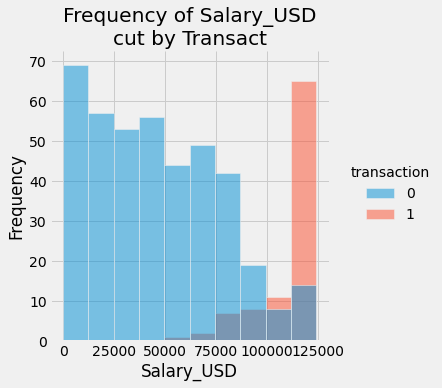

In [ ]:
# Plot the histogram of salary_usd cut by transact
ax = sns.displot(data = df2,x = 'salary_usd', hue='transaction')
plt.title('Frequency of Salary_USD\ncut by Transact')
plt.xlabel('Salary_USD')
plt.ylabel('Frequency')


## Implement Logistic Regression

### Create dummy variables for categorical features

In [ ]:
# Show the column names
list(df2.columns)

['transaction',
 'salary_usd',
 'is_male',
 'is_married',
 'is_college',
 'is_professional',
 'is_senior',
 'is_employed',
 'is_single_income',
 'children_present',
 'is_renter',
 'lives_in_house',
 'is_english_primary_language',
 'previously_disney_customer',
 'previous_streaming_service_customer']

In [ ]:
# Create dummy variables for each categorical feature, then join them into df2 dataframe
cat2_vars = df2.columns.values.tolist()
cat2_vars.remove('transaction')
cat2_vars.remove('salary_usd')
for var in cat2_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df2[var], prefix=var)
    df_t=df2.join(cat_list)
    df2=df_t

# Remove the original categorical variables
df2_vars = df2.columns.values.tolist()
to_keep = [i for i in df2_vars if i not in cat2_vars]

# Select the converted categorical variables and numerical variables as new dataframe 
df2_final=df2[to_keep]
df2_final.columns.values

array(['transaction', 'salary_usd', 'is_male_0', 'is_male_1',
       'is_married_0', 'is_married_1', 'is_college_0', 'is_college_1',
       'is_professional_0', 'is_professional_1', 'is_senior_0',
       'is_senior_1', 'is_employed_0', 'is_employed_1',
       'is_single_income_0', 'is_single_income_1', 'children_present_0',
       'children_present_1', 'is_renter_0', 'is_renter_1',
       'lives_in_house_0', 'lives_in_house_1',
       'is_english_primary_language_0', 'is_english_primary_language_1',
       'previously_disney_customer_0', 'previously_disney_customer_1',
       'previous_streaming_service_customer_0',
       'previous_streaming_service_customer_1'], dtype=object)

### Feature selction

In [ ]:
# Split X and Y for prediction
df2_final_vars = df2_final.columns.values.tolist()
Y = ['transaction']
X = [i for i in df2_final_vars if i not in Y ]
#X

In [ ]:
# Decide the columns that are more significant
model = LogisticRegression()
rfe = RFE(model, 20)
rfe2 = rfe.fit(df2_final[X],df2_final[Y])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Select the columns that rank at 1
rank_dict2 = {X[i]: rfe2.ranking_[i] for i in range(len(X))}
rev_dict2 = {} 
for key, value in rank_dict2.items(): 
    rev_dict2.setdefault(value, set()).add(key)
result2 = list(filter(lambda x: len(x)>1, rev_dict2.values())) 
#result2

In [ ]:
# Set the X and Y for the model
cols = list(result2[0])
X = df2_final[cols]
Y = df2_final['transaction']

### Implement logistic regression model

In [ ]:
# Split the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .30,random_state=101)

# Fit in model
model = LogisticRegression()
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

model.score(X_test, y_test)

0.8289473684210527

### Sample prediction

In [ ]:
# Samples of the actuals, predictions, and probabilities
prediction_df = pd.DataFrame(y_pred, columns = {'Prediction'}).set_index([pd.Index(X_test.index)])
probability_df = pd.DataFrame(model.predict_proba(X_test)).set_index([pd.Index(X_test.index)])
combined_df = X_test.join(y_test).join(prediction_df).join(probability_df)
combined_df.head(5)

,is_college_0,previous_streaming_service_customer_1,is_professional_1,is_english_primary_language_0,is_english_primary_language_1,previously_disney_customer_1,previously_disney_customer_0,is_renter_0,is_professional_0,is_employed_1,is_renter_1,lives_in_house_1,previous_streaming_service_customer_0,is_single_income_1,is_employed_0,lives_in_house_0,is_married_0,is_college_1,is_married_1,is_senior_1,transaction,Prediction,0,1
row,,,,,,,,,,,,,,,,,,,,,,,,
243,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,1,1,0,0,0,0,0,0.975846,0.024154
667,0,0,0,0,1,0,1,1,1,0,0,1,1,1,1,0,0,1,1,1,1,0,0.786504,0.213496
511,1,0,1,0,1,0,1,1,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0.818085,0.181915
672,1,0,1,0,1,0,1,1,0,0,0,1,1,0,1,0,0,0,1,0,1,1,0.466592,0.533408
637,1,0,0,0,1,0,1,1,1,0,0,1,1,1,1,0,0,0,1,1,0,0,0.862194,0.137806


### Performance of model

In [ ]:
# Accuracy of the model
print('Accuracy of logistic regression prediction on test set: {:.3f}'.format(model.score(X_test, y_test)))
print()

# Classification report
print(classification_report(y_test, y_pred))

Accuracy of logistic regression prediction on test set: 0.829

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       123
           1       0.60      0.31      0.41        29

    accuracy                           0.83       152
   macro avg       0.73      0.63      0.65       152
weighted avg       0.81      0.83      0.81       152



# Regularization:(Ridge and Lasso)
## Predict salaries for a sports player.

### Acquire data

In [ ]:
path_3 = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSzbNvy6VkpDeHgxTjzBPsA4v8FwJbLtclQscxUdngJLZ3ERLi1AjeZjeXBz5cCJQQPqLvKkDce46s5/pub?gid=2016106659&single=true&output=csv"
df3 = pd.read_csv(path_3)
df3.shape

(243, 20)

In [ ]:
df3.head()

,Salary,count_at_bats,count_hits,count_home_runs,count_runs,RBI,count_walks,years_experience,cumulative_at_bats,cumulative_hits,cumulative_home_runs,cumulative_runs,cumulative_RBI,cumulative_walks,League,Division,PutOuts,Assists,Errors,NewLeague
0,875000,457,101,14,42,63,22,17,6521,1767,281,1003,977,619,A,W,389,39,4,A
1,1300000,441,118,28,84,86,68,8,2723,750,126,433,420,309,A,E,190,2,2,A
2,940000,593,152,23,69,75,53,6,2765,686,133,369,384,321,A,W,315,10,6,A
3,70000,312,68,2,32,22,24,1,312,68,2,32,22,24,A,E,86,150,15,A
4,815000,526,146,13,71,70,84,6,2648,715,77,352,342,289,N,W,303,9,9,N


### Description of quantitative variables

In [ ]:
df3.describe()

,Salary,count_at_bats,count_hits,count_home_runs,count_runs,RBI,count_walks,years_experience,cumulative_at_bats,cumulative_hits,cumulative_home_runs,cumulative_runs,cumulative_RBI,cumulative_walks,PutOuts,Assists,Errors
count,2.430000e+02,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,3.964856e+05,377.621399,99.975309,10.666667,50.123457,47.362140,38.115226,7.473251,2654.497942,717.703704,71.831276,362.061728,332.069959,263.711934,284.263374,102.781893,7.629630
std,4.205241e+05,151.221516,45.997478,8.449656,25.186109,25.642821,21.239171,5.018386,2344.518332,657.431235,88.616130,337.841166,333.997166,277.955388,275.126756,134.263086,6.244557
min,0.000000e+00,16.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,19.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000e+04,255.500000,64.000000,4.000000,31.000000,29.000000,22.000000,4.000000,826.500000,209.500000,14.000000,100.500000,91.500000,66.500000,113.500000,6.500000,3.000000
50%,2.500000e+05,360.000000,95.000000,8.000000,48.000000,44.000000,34.000000,6.000000,1931.000000,510.000000,39.000000,258.000000,230.000000,174.000000,211.000000,33.000000,6.000000
75%,6.665000e+05,511.000000,136.000000,16.000000,68.500000,63.500000,52.000000,11.000000,3890.500000,1037.500000,93.000000,523.500000,424.500000,329.500000,322.500000,151.500000,10.000000
max,1.975000e+06,687.000000,238.000000,40.000000,117.000000,121.000000,105.000000,24.000000,14053.000000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000


- There is an zero in the Salary, which should not be considered in the dataframe, that we can drop the records have zero in Salary column.

In [ ]:
# drop the records that hold the value of 0 in Salary column
df3 = df3.loc[df3['Salary']!=0]
df3.shape

(184, 20)

### Create dummies varialbes

In [ ]:
# Create dummy variables for each categorical feature, then join them into df2 dataframe
cat3_vars = ['League','Division','NewLeague']
for var in cat3_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df3[var], prefix=var)
    df_t=df3.join(cat_list)
    df3=df_t

# Remove the original categorical variables
df3_vars = df3.columns.values.tolist()
to_keep = [i for i in df3_vars if i not in cat3_vars]

# Select the converted categorical variables and numerical variables as new dataframe 
df3_final = df3[to_keep]
#df3_final.columns.values

In [ ]:
# Split X and Y for prediction
df3_final_vars = df3_final.columns.values.tolist()
y_col = ['Salary']
x_col = [i for i in df3_final_vars if i not in y_col ]

X = df3_final[x_col]
Y = df3_final[y_col]
#list(X.columns)

### Split the train and test datasets

In [ ]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 33)

### Ridge

In [ ]:
# Set a list of alpha
alphas = np.logspace(-7,2,10)

#col = ['SSE','AIC','MSE','R^2']
col = ['MSE','RMSE','R^2','SSE','AIC'] + ['coef_'+i for i in x_col]
ind = ['alpha_%.2g'%alphas[i] for i in range(len(alphas))]
ridge_matrix = pd.DataFrame(index=ind, columns=col)

for i in range(len(alphas)):
  ridge = Ridge(alpha = alphas[i],normalize=True)
  ridge.fit(X_train,y_train)
  y_pred = ridge.predict(X_test)
  mse = mean_squared_error(y_test,y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test,y_pred)
  sse = sum(((y_pred-y_test)**2)['Salary'].values)
  # aic = n*log(sse/n)+2(k+1), k = number of predictor, k+1 = include intercept
  aic = len(df3_final)*np.log(sse/len(df3_final)) + 2*(len(df3_final.columns))
  ret = [mse]
  ret.extend([rmse])
  ret.extend([r2])
  ret.extend([sse])
  ret.extend([aic])
  ret.extend(ridge.coef_[0])
  ridge_matrix.iloc[i,] = ret

ridge_matrix

,MSE,RMSE,R^2,SSE,AIC,coef_count_at_bats,coef_count_hits,coef_count_home_runs,coef_count_runs,coef_RBI,coef_count_walks,coef_years_experience,coef_cumulative_at_bats,coef_cumulative_hits,coef_cumulative_home_runs,coef_cumulative_runs,coef_cumulative_RBI,coef_cumulative_walks,coef_PutOuts,coef_Assists,coef_Errors,coef_League_A,coef_League_N,coef_Division_E,coef_Division_W,coef_NewLeague_A,coef_NewLeague_N
alpha_1e-07,1.1302e+11,336185,0.506064,6.32914e+12,4510.07,-1059.3,5629.58,11759.6,-1950.5,-3179.17,7527.36,12727.3,-158.97,119.741,-1557.09,1276.78,960.46,-954.096,128.619,170.51,164.357,-12043.8,12043.8,44102.5,-44102.5,14147.8,-14147.8
alpha_1e-06,1.13022e+11,336188,0.506056,6.32925e+12,4510.07,-1059.31,5629.32,11757.9,-1949.85,-3178.62,7527.06,12723.3,-158.91,119.86,-1556.32,1276.32,960.067,-953.994,128.62,170.482,163.922,-12043.6,12043.6,44102.8,-44102.8,14149.7,-14149.7
alpha_1e-05,1.13042e+11,336217,0.505969,6.33035e+12,4510.11,-1059.38,5626.71,11741.1,-1943.47,-3173.11,7524.11,12683,-158.321,121.036,-1548.61,1271.73,956.158,-952.984,128.63,170.208,159.598,-12040.8,12040.8,44106.4,-44106.4,14168.2,-14168.2
alpha_0.0001,1.13238e+11,336508,0.505115,6.34131e+12,4510.42,-1060,5602.24,11581.5,-1883.13,-3120.87,7496.09,12292.6,-152.545,131.559,-1476.12,1228.33,919.207,-943.437,128.738,167.516,118.684,-12007.4,12007.4,44140.9,-44140.9,14337.3,-14337.3
alpha_0.001,1.14946e+11,339036,0.49765,6.43696e+12,4513.18,-1058.17,5427.72,10481.4,-1474.66,-2764.94,7292.67,9412.78,-107.702,178.901,-1019.53,941.888,679.187,-878.71,129.899,145.888,-152.904,-11531.5,11531.5,44422.4,-44422.4,15172.9,-15172.9
alpha_0.01,1.2125e+11,348210,0.470098,6.78999e+12,4523,-826.132,4323.17,7371.12,-205.204,-1728.58,6320.2,3844.81,-8.99172,194.746,-338.435,373.238,272.87,-664.694,132.582,77.2135,-760.31,-10183.8,10183.8,45045.1,-45045.1,13880.6,-13880.6
alpha_0.1,1.29671e+11,360098,0.433297,7.26155e+12,4535.36,-93.5957,1914.28,2721.81,1390.54,71.5469,3635.41,4689.85,16.2276,110.937,-195.221,129.81,114.738,-224.136,138.119,-5.14803,-1137.64,-8963.24,8963.24,42536,-42536,4909.93,-4909.93
alpha_1,1.39212e+11,373111,0.391598,7.79587e+12,4548.42,177.83,885.794,1652.5,1375.88,798.725,1653.5,3861.44,10.6343,46.3538,74.085,74.1498,63.0137,20.9769,102.022,2.15363,-373.51,-1867.69,1867.69,29345.2,-29345.2,-861.65,861.65
alpha_10,1.83102e+11,427904,0.199784,1.02537e+13,4598.85,82.7273,294.604,1010.54,516.35,435.397,551.914,1751.47,4.52206,17.0673,93.3151,31.6091,31.4177,27.6871,30.8198,8.30495,61.3971,2751.51,-2751.51,7166.9,-7166.9,2116.57,-2116.57
alpha_1e+02,2.28428e+11,477942,0.00169297,1.2792e+13,4639.54,12.3521,42.0087,163.068,75.0828,67.9227,80.6013,287.11,0.723157,2.66687,16.5347,5.04859,5.16559,4.84182,4.22499,1.25882,8.64075,652.558,-652.558,800.037,-800.037,550.456,-550.456


- We can see that when alpha decreases, the RMSE decreases and R^2 score increases. 
- As the alpha increases, coefficients are getting close to zero.

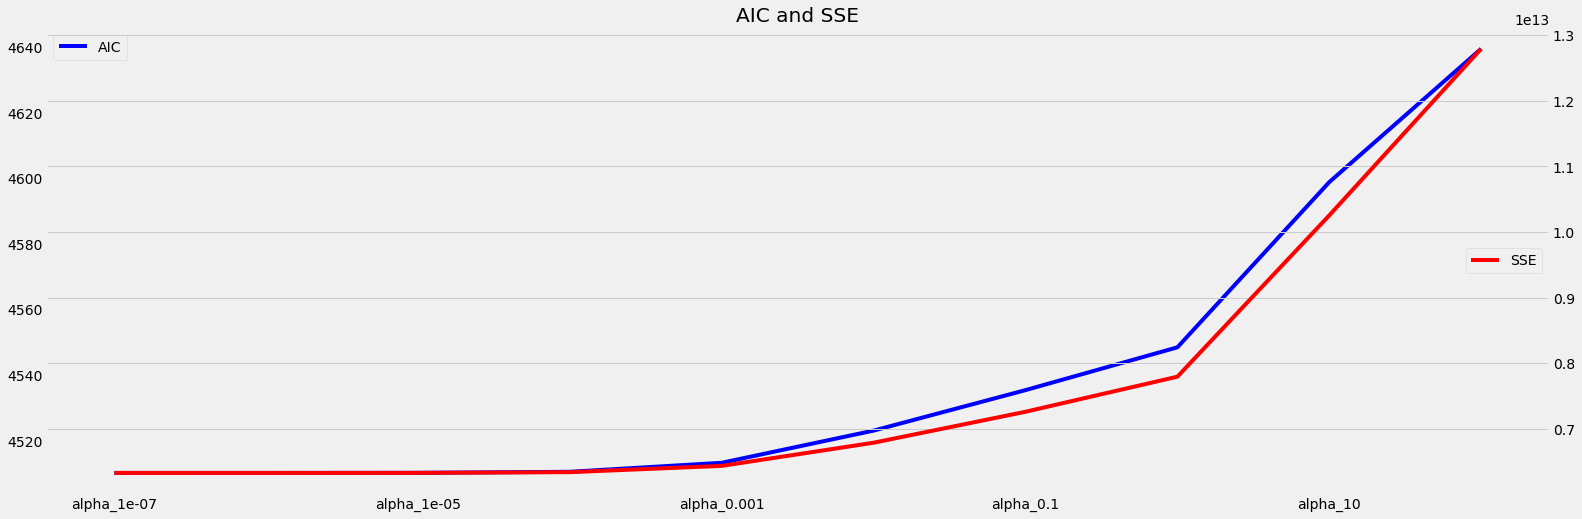

In [ ]:
# AIC and SSE graph
ax1 = ridge_matrix.AIC.plot(color = 'blue')
plt.legend(loc = 'center left')
ax2 = ridge_matrix.SSE.plot(color = 'red', secondary_y = True)
plt.legend(loc = 'center right')
plt.title('AIC and SSE')
plt.xlabel('alpha')
plt.show()

### Lasso

In [ ]:
# Set a list of alpha
alphas = np.logspace(-7,3,11)

col = ['MSE','RMSE','R^2'] + ['coef_'+i for i in x_col]
#col = ['MSE','R^2','SSE','AIC']
ind = ['alpha_%.2g'%alphas[i] for i in range(len(alphas))]
lasso_matrix = pd.DataFrame(index=ind, columns=col)

for i in range(len(alphas)):
  lasso = Lasso(alpha = alphas[i],normalize=True)
  lasso.fit(X_train,y_train)
  y_pred = lasso.predict(X_test)
  mse = mean_squared_error(y_test,y_pred)
  r2 = r2_score(y_test,y_pred)
  rmse = np.sqrt(mse)
  #sse = sum((y_pred-y_test.values[0])**2)
  # aic = n*log(sse/n)+2(k+1), k = number of predictor, k+1 = include intercept
  #aic = len(df3_final)*np.log(sse/len(df3_final)) + 2*(len(df3_final.columns))
  ret = [mse]
  ret.extend([rmse])
  ret.extend([r2])
  #ret.extend([sse])
  #ret.extend([aic])
  ret.extend(lasso.coef_)
  lasso_matrix.iloc[i,] = ret

lasso_matrix


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3540714776276.1504, tolerance: 1736893871.875
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3540714286813.9214, tolerance: 1736893871.875
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3540709392196.257, tolerance: 1736893871.875
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3540660446497.5903,

,MSE,RMSE,R^2,coef_count_at_bats,coef_count_hits,coef_count_home_runs,coef_count_runs,coef_RBI,coef_count_walks,coef_years_experience,coef_cumulative_at_bats,coef_cumulative_hits,coef_cumulative_home_runs,coef_cumulative_runs,coef_cumulative_RBI,coef_cumulative_walks,coef_PutOuts,coef_Assists,coef_Errors,coef_League_A,coef_League_N,coef_Division_E,coef_Division_W,coef_NewLeague_A,coef_NewLeague_N
alpha_1e-07,1.12666e+11,335658,0.507612,-1023.58,5388.61,11336.2,-1713.98,-3008.01,7409.06,13877.8,-188.268,272.929,-1290.78,1175.52,863.248,-919.115,126.067,182.491,54.5873,-27304.1,1.8005e-12,87715.6,-0,31179.8,-0
alpha_1e-06,1.12666e+11,335658,0.507612,-1023.58,5388.61,11336.2,-1713.98,-3008.01,7409.06,13877.8,-188.268,272.929,-1290.78,1175.52,863.248,-919.115,126.067,182.491,54.5873,-27304.1,0,87715.6,-0,31179.8,-5.15102e-12
alpha_1e-05,1.12666e+11,335658,0.507612,-1023.58,5388.61,11336.2,-1713.98,-3008.01,7409.06,13877.8,-188.268,272.929,-1290.78,1175.52,863.247,-919.115,126.067,182.491,54.5872,-27304.1,0,87715.6,-0,31179.8,-5.93268e-12
alpha_0.0001,1.12666e+11,335658,0.507612,-1023.58,5388.61,11336.2,-1713.98,-3008.01,7409.06,13877.8,-188.268,272.928,-1290.78,1175.51,863.247,-919.115,126.067,182.491,54.5863,-27304,1.74925e-11,87715.6,-0,31179.8,-5.93601e-12
alpha_0.001,1.12666e+11,335658,0.507612,-1023.58,5388.6,11336.1,-1713.96,-3007.99,7409.05,13877.6,-188.265,272.925,-1290.76,1175.51,863.238,-919.113,126.067,182.489,54.5769,-27303.8,4.62394e-12,87715.6,-0,31179.6,-0
alpha_0.01,1.12667e+11,335659,0.507609,-1023.59,5388.57,11335.6,-1713.81,-3007.82,7408.98,13875.9,-188.235,272.894,-1290.63,1175.42,863.155,-919.097,126.069,182.475,54.4834,-27301,0,87715.7,-0,31178.1,-0
alpha_0.1,1.12674e+11,335670,0.507576,-1023.67,5388.23,11330.3,-1712.31,-3006.15,7408.22,13858.4,-187.933,272.585,-1289.24,1174.52,862.319,-918.935,126.086,182.329,53.5486,-27273.8,0,87716.9,-0,31162.3,-5.20758e-13
alpha_1,1.12749e+11,335782,0.507248,-1024.56,5384.85,11276.7,-1697.29,-2989.4,7400.66,13683.8,-184.919,269.502,-1275.41,1165.56,853.962,-917.31,126.255,180.876,44.1956,-27001.2,0,87728.3,-0,31005.2,-0
alpha_10,1.13584e+11,337022,0.503602,-1033.67,5350.96,10736,-1545.85,-2821.76,7325.11,11954.8,-155.029,239.722,-1134.47,1075.7,769.702,-901.089,127.922,165.038,-0,-24220.5,7.74098e-12,87786.4,-1.03099e-11,29431.3,-2.60443e-12
alpha_1e+02,1.22176e+11,349537,0.466052,-939.088,4433.15,6180.94,-0,-1314.42,6418.99,2166.87,-0,241.602,-0,322.799,136.642,-695.422,132.002,54.5058,-221.087,-5077.39,3.87049e-12,86871.9,-1.03099e-11,15981.5,-8.46439e-12


- This Lasso model perfoms like Ridge model above:
  - When alpha decreases, the RMSE decreases and R^2 score increases. 
  - As the alpha increases, coefficients are getting close to zero.
- However, for my point of view, after cleansing data we have only 184 data to test the Ridge and Lasso models are quite not enough that we can only get low R^2 score and high RMSE. To get a better fit model, we should aquire more data to investigate.

# Reference:
- Ashish Kumar (2016) Learning Predictive Analytics with Python. Implementing logistic regression with Python.
- Dainel Lenz (Aug 7,2018) Subplot in matplotlib.
https://stackoverflow.com/questions/51736396/subplots-in-matplotlib-give-valueerror-not-enough-values-to-unpack/51736488
- Matplotlib Basic pie chart.
https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
-  manjeet_04 (Nov 28,2018) Convert two lists into a dictionary
https://www.geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/
- garg_ak0109 (Aug 07, 2019) Find keys with duplicate values in dictionary
https://www.geeksforgeeks.org/python-find-keys-with-duplicate-values-in-dictionary/


